**FIT3183 Malicious AI & Dark Side Security**
# Lab 5: Generative Adversarial Network (Solution)

*This is the Colab Notebook for the Solution of [this assignment](https://colab.research.google.com/drive/1bscyXlpJ4hppt5raesQfkQBrp1FOdzIY?usp=sharing).*

There are 2 tasks:
* Implement your first GAN: Handwritten digits generator 
* Synthesize face images with DCGAN (on Kaggle)

👉 ***Copy this Colab notebook to your Drive***, read the instruction and fill the missing code.

👉 ***Use GPU:*** `Runtime > Change runtime type > GPU`.

*Note: If you are new to Google Colab and Pytorch: please read this [Pre-lab Activities](https://drive.google.com/file/d/1aBOkxvGxkOeZlZxYQy0xiEzdEwU-C1DX/view?usp=sharing) first.*

<small>*Prepared by [Linh Vu](mailto:linh.vu@monash.edu) (Lab Tutor) Aug 2020.*

## Task 1: Implement your first GAN - Handwritten digits generator 

Generative adversarial networks are machine learning systems that can learn to mimic a given distribution of data. GANs consist of two neural networks:

* Generator, which is trained to generate data by learning the distribution of the training set;
* Discriminator, which is trained to distinguish fake data from real data.

In this task, we are going to implement a simple GAN to generate images of handwritten digits with the MNIST dataset of handwritten digits with Pytorch.

There are 3 subtasks:
* Implement the Discriminator
* Implement the Generator
* Training the models

<img src="http://limg.surge.sh/gan_mnist.jpg" width=600>

### Initialization

First, we setup environment & prepapre data.

In [1]:
import torch
from torch import nn

import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

import numpy as np
from matplotlib import rcParams
rcParams["savefig.jpeg_quality"] = 50
import imageio
from pathlib import Path
# we don't like warnings
# you can comment the following 2 lines if you'd like to
import warnings
warnings.filterwarnings('ignore')

# Set up a random generator seed so that the experiment can be replicated identically on any machine
torch.manual_seed(111)

# Create a device object that points to the CPU or GPU if available
device = ""
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

# Define the transform to load grayscale images from MNIST dataset
# Note that grayscale images have only one channel
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))
                              ])

# Load MNIST dataset
train_set = torchvision.datasets.MNIST(
  root=".", train=True, download=True, transform=transform
)

# Create a data loader to shuffle the data from train_set and return 
# batches of 32 samples used for networks training
batch_size = 32
train_loader = torch.utils.data.DataLoader(
  train_set, batch_size=batch_size, shuffle=True, drop_last=True
)

The MNIST dataset consists of 28 × 28 pixel grayscale images of handwritten digits from 0 to 9. Let's visualize the data to see. Since GANs make use of unsupervised learning techniques, we don't need to care about the label.

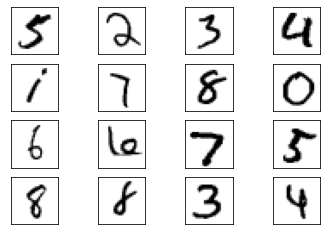

In [2]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
  plt.xticks([])
  plt.yticks([])

The MNIST dataset consists of digits with different handwriting styles. As the GAN learns the distribution of the data, it will also generate digits with different handwriting styles.

Now let's implement the discriminator and generator models.

### Subtask 1.1: Implement the Discriminator

The discriminator is model that receives a 28 × 28 pixel image from the real data or from the generator and provides the probability of the image belonging to the real training data. 

***> What is the number of neuron for the input layer and output layer?***

**Task: Implement the discriminator, which is a MLP model with:**

* Input layer: `__` neurons (to process the image vector)
* 1st hidden layer: 1024 neurons, activation: ReLU, dropout (to avoid overfitting): 0.3
* 2nd hidden layer: 512 neurons, activation: ReLU, dropout: 0.3
* 3rd hidden layer: 256 neurons, activation: ReLU, dropout: 0.3
* Output layer: `__` neurons, activation: Sigmoid (to return the probability in range `[0, 1]`)

In [3]:
# Create class for the discriminator model that inherit from nn.Module

class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
      ## YOUR CODE HERE ##
      # Input layer: __ neurons. 1st hidden layer: 1024 neurons, activation: ReLU, dropout: 0.3 (3 lines)
      nn.Linear(784, 1024),
      nn.ReLU(),
      nn.Dropout(0.3),
      
      # 2nd hidden layer: 512 neurons, activation: ReLU, dropout: 0.3 (3 lines)
      nn.Linear(1024, 512),
      nn.ReLU(),
      nn.Dropout(0.3),

      # 3rd hidden layer: 256 neurons, activation: ReLU, dropout: 0.3 (3 lines)
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Dropout(0.3),

      # Output layer: __ neurons, activation: Sigmoid (2 lines)
      nn.Linear(256, 1),
      nn.Sigmoid(),
      ## END YOUR CODE HERE ##
    )

  def forward(self, x):
    """
    Input: 
      x: tensor of images with shape: batch_size x channel x width x height (32 x 1 x 28 x 28)
    Return: 
      output: the probability of x belong to the real training data, shape: batch_size x 1 (32 x 1)
    """
    # Change x shape to: batch_size x dimension_of_input_layer (32 x 784)
    x = x.view(x.size(0), 784)

    # Feed x to the model to predict the probability
    output = self.model(x)

    return output

In [4]:
# Create a Discriminator object and send it to GPU if available
discriminator = Discriminator().to(device=device)

### Subtask 1.2: Implement the Generator

In GANs, the generator takes samples from a latent space as its input and generates data resembling the data in the training set. In this case, the generator is going to be fed a 100-dimensional input, which is sufficient to generate images of handwritten digits. Then, it will provide an output with `__` coefficients, which will be organized in a 28 × 28 tensor representing an image.

The implementation is similar to what you did for the discriminator.

***> What is the number of neuron for the input layer and output layer?***

**Task: Implement the generator:**
* Define the neural network architectures in `__init__` function:
  * Input layer: `__` neurons (to process the latent vectors)
  * 1st hidden layer: 256 neurons, activation: ReLU
  * 2nd hidden layer: 512 neurons, activation: ReLU
  * 3rd hidden layer: 1024 neurons, activation: ReLU
  * Output layer: `__` neurons, activation: Tanh (to return the vector of coefficients with values in range `[-1, 1]` to generate image)
* Describe the training process in `forward` function:
  * Feed x to the model to generate vectors
  * Change the output shape to get the tensor of images
* Create a Generator object and send it to GPU if available

In [5]:
# Create class for the generator model that inherit from nn.Module

class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    ## YOUR CODE HERE ##
    # Define the neural network architectures
    self.model = nn.Sequential(
      nn.Linear(100, 256),
      nn.ReLU(),
      nn.Linear(256, 512),
      nn.ReLU(),
      nn.Linear(512, 1024),
      nn.ReLU(),
      nn.Linear(1024, 784),
      nn.Tanh(),
    )
    ## END YOUR CODE HERE ##

  def forward(self, x):
    """
    Input: 
      x: tensor of latent vectors with shape: batch_size x dimension_of_latent_vector (32 x 100)
    Return: 
      output: tensor of generated images with shape: batch_size x channel x width x height (32 x 1 x 28 x 28)
    """
    ## YOUR CODE HERE ##
    # Feed x to the model to generate vectors (1 line)
    output = self.model(x)
    # Change the output shape to get the tensor of images (1 line)
    output = output.view(x.size(0), 1, 28, 28)
    ## END YOUR CODE HERE ##

    return output

In [6]:
## YOUR CODE HERE ##
# Create a Generator object and send it to GPU if available (1 line)
generator = Generator().to(device=device)

### Prepare for training

Before training the models, we set up some parameters to use during training: learning rate, loss function, optimization algorithm, as well as define some helper classes to support visualization.

Set up parameters for training process:

In [7]:
# learning rate: used to adapt the network weights
lr = 0.0001
# loss function: binary cross-entropy
loss_function = nn.BCELoss()
# create the optimizers using Adam algorithm for both models
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

Define helper functions to support visualization: We want to create an animation like this to illustrate how the generator learn to generate more realistic data:

<img src="https://files.realpython.com/media/fig_gan_mnist.5d8784a85944.gif" width=400>

In [8]:
import base64
from IPython import display

def show_gif(file_path):
  """
  To show gif or video in Colab, we need to load the data and encode with base64.
  """
  with open(file_path, 'rb') as file:
    b64 = base64.b64encode(file.read()).decode('ascii')
  return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')


# Randomize tensor of latent vectors and use it to visualize the training process
fixed_latent_vectors = torch.randn((batch_size, 100)).to(device=device) 

def generate_images(title=False, output_path=False, show=True):
  """
  Generate images from a random vector using the generator.
  Input:
    title: title of the image showing how many epochs that the generator is trained
    output_path: if you want to save file, define the output folder 
    show: display the plot or not. Set to False if you just want to save the image
  Output:
    file_path: path of the generated image file
  """
  # Generate data from latent vectors with the generator 
  generated_samples = generator(fixed_latent_vectors)
  # Move the data back to the CPU and create a view of data (without gradients)
  generated_samples = generated_samples.cpu().detach()
  # Plot the data
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])
    if i == 0 and title:
      ax.set(title=title)
  # Save to file  
  file_path = ""       
  if output_path:
    Path(output_path).mkdir(parents=True, exist_ok=True)
    file_path = f"{output_path}/{epoch:0=3d}.jpg"
    plt.savefig(file_path)
  # Close the plot if not show
  if not show:
    plt.close('all')
  # Return path of the generated image file
  return file_path

Let's see what the generator can do before training:

''

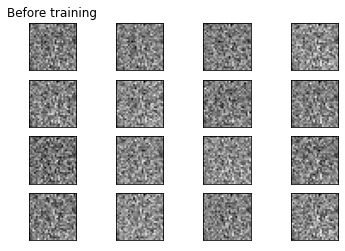

In [9]:
generate_images(title='Before training')

### Subtask 1.3: Training the models

The GAN training process consists of a two-player minimax game in which:
* D is adapted to minimize the discrimination error between real and generated samples;
* G is adapted to maximize the probability of D making a mistake.

**Tasks:**
* Set number of epochs: how many repetitions of training with the whole dataset.
    * It decides how many times we will change the weights of the network.
* Create tensors of labels for real data with `value=1` and generated data with `value=0`
    * hints: [torch.ones](https://pytorch.org/docs/stable/generated/torch.ones.html), [torch.cat](https://pytorch.org/docs/stable/generated/torch.cat.html)
* Define the function `train_generator` (similar to `train_discriminator`)
* Define steps to train the models and run the training process

After that, visualize your training process and the final result.

In [10]:
# Get total number of batches. We print the losses after training the last batch of each epoch
num_batches = len(train_loader)

## YOUR CODE HERE ##
# Set how many repetitions of training with the whole dataset (1 line)
num_epochs = 50

# Because the labels remain the same for every batch, we create it here:
# Create tensor of labels for real samples with value=1 and shape is batch_size x 1 (1 line)
real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
# Create tensor of labels for generated samples with value=0 and shape is batch_size x 1 (1 line)
generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
# Create tensor of labels for all samples from the two tensors above using torch.cat (1 line)
all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))
## END CODE HERE ##

# Set where to save the generated image files
output_path = './output'
output_files = []

# Save the losses to visualize
losses_discriminator, losses_generator = [], []

Function to train the discriminator:

In [11]:
def train_discriminator(real_samples):
  """
  Train the discriminator model by minimizing its error.
  Input: 
    real_samples: tensor of images with shape: batch_size x channel x width x height
  Return:
    loss_discriminator: for printing purpose
  """  
  # Randomize tensor of latent vectors and send to GPU if available 
  latent_vectors = torch.randn((batch_size, 100)).to(device=device) 
  # Generate data from latent vectors with the generator
  generated_samples = generator(latent_vectors)
  # Combine real and generated data
  all_samples = torch.cat((real_samples, generated_samples))

  # Clear the gradients of the discriminator to avoid accumulating them
  discriminator.zero_grad()
  # Train the discriminator with the combined data
  output_discriminator = discriminator(all_samples)
  # Calculate the loss function for the discriminator to minimize its error
  loss_discriminator = loss_function(output_discriminator, all_samples_labels)
  # Calculate the gradients for the discriminator
  loss_discriminator.backward()
  # Update the weights of the discriminator
  optimizer_discriminator.step()

  return loss_discriminator

* Define the function to train the generator:

In [12]:
def train_generator():
  """
  Train the generator model by maximizing the discriminator error.
  Return:
    loss_generator: for printing purpose
  """   
  ## YOUR CODE HERE ##
  # Randomize tensor of latent vectors and send to GPU if available
  latent_vectors = torch.randn((batch_size, 100)).to(device=device)

  # Clear the gradients of the generator to avoid accumulating them (1 line)
  generator.zero_grad()
  # Train the generator with the latent data (1 line)
  generated_samples = generator(latent_vectors)
  # Get the discriminator prediction on the generator's output (1 line)
  output_discriminator_generated = discriminator(generated_samples)
  # Calculate the loss function for the generator to maximize the discriminator error (1 line)
  loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
  # Calculate the gradients for the generator (1 line)
  loss_generator.backward()
  # Update the weights of the generator (1 line)
  optimizer_generator.step()

  ## END YOUR CODE HERE ##

  return loss_generator

Let's train the models! Training 50 epochs with GPU on Colab will take ~15 minutes (without GPU: 50 minutes).

In [13]:
# Repeat the training process based on the number of epochs
for epoch in range(num_epochs):
  # Load training data by batches
  for batch, (real_samples, _) in enumerate(train_loader):

    ## YOUR CODE HERE ##
    # Send real samples from data loader to GPU if available (1 line)
    real_samples = real_samples.to(device=device)   
    # Train the discriminator (1 line)
    loss_discriminator = train_discriminator(real_samples)
    # Train the generator (1 line)
    loss_generator = train_generator()
    ## END YOUR CODE HERE ##

    losses_discriminator += [loss_discriminator]
    losses_generator += [loss_generator]

    # Print losses
    if batch == num_batches - 1:
      print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
      print(f"Epoch: {epoch} Loss G.: {loss_generator}")
      title = f"After {epoch} epoch(s)"
      output_files += [generate_images(title, output_path=output_path, show=False)]

Epoch: 0 Loss D.: 0.028781790286302567
Epoch: 0 Loss G.: 5.341374397277832
Epoch: 1 Loss D.: 0.09296402335166931
Epoch: 1 Loss G.: 10.221760749816895
Epoch: 2 Loss D.: 0.004699907265603542
Epoch: 2 Loss G.: 6.309975624084473
Epoch: 3 Loss D.: 0.01625100150704384
Epoch: 3 Loss G.: 4.762054443359375
Epoch: 4 Loss D.: 0.10697653889656067
Epoch: 4 Loss G.: 6.225358963012695
Epoch: 5 Loss D.: 0.09737011045217514
Epoch: 5 Loss G.: 2.7727255821228027
Epoch: 6 Loss D.: 0.25234466791152954
Epoch: 6 Loss G.: 2.4245247840881348
Epoch: 7 Loss D.: 0.29544520378112793
Epoch: 7 Loss G.: 2.1807518005371094
Epoch: 8 Loss D.: 0.33987241983413696
Epoch: 8 Loss G.: 1.7162662744522095
Epoch: 9 Loss D.: 0.41354066133499146
Epoch: 9 Loss G.: 1.6785590648651123
Epoch: 10 Loss D.: 0.38039180636405945
Epoch: 10 Loss G.: 1.4646838903427124
Epoch: 11 Loss D.: 0.4154926836490631
Epoch: 11 Loss G.: 1.7066106796264648
Epoch: 12 Loss D.: 0.49997901916503906
Epoch: 12 Loss G.: 1.8945497274398804
Epoch: 13 Loss D.: 0.4

Visualize the losses during training:

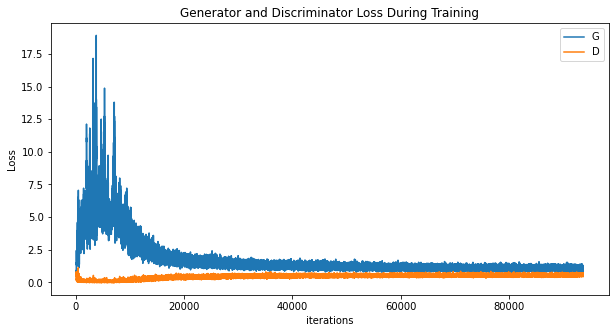

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(losses_generator,label="G")
plt.plot(losses_discriminator,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Visualize the training process:

In [15]:
# Make gif from list of images
images = [imageio.imread(file) for file in output_files]
imageio.mimsave('results.gif', images, fps=10)
show_gif('results.gif')

Output hidden; open in https://colab.research.google.com to view.

''

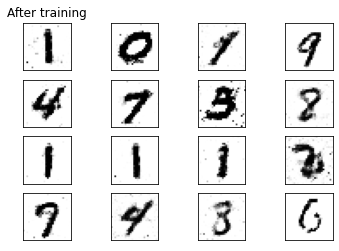

In [16]:
generate_images(title='After training')

You've implemented & train your first GAN. Congrats!

Now let's train a more complex GAN to generate images of fake faces using CelebA dataset on Kaggle.

## Task 2: Synthesize face images with DCGAN (on Kaggle)